In [1]:
import intake
import healpy as hp
import matplotlib.pyplot as plt
from easygems.healpix import attach_coords

In [2]:
hera_cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/internal.yaml")
hera = hera_cat.HERA5(chunks="auto").to_dask().pipe(attach_coords)
# Contains modified Copernicus Climate Change Service information 2023.
# Neither the European Commission nor ECMWF is responsible for any use
# that may be made of the Copernicus information or data it contains.
# This dataset is on healpix level 7

/usr/local/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [3]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/online.yaml")
zoom = 7
icon = cat.ICON.ngc3028(zoom=zoom, chunks="auto").to_dask().pipe(attach_coords)

timeslice = slice("2020-02-01", "2023-01-31")
t_mean_model = icon.sel(time=timeslice).tas.mean(dim="time")
t_mean_obs = hera.sel(time=timeslice)["2t"].mean(dim="time")

/usr/local/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


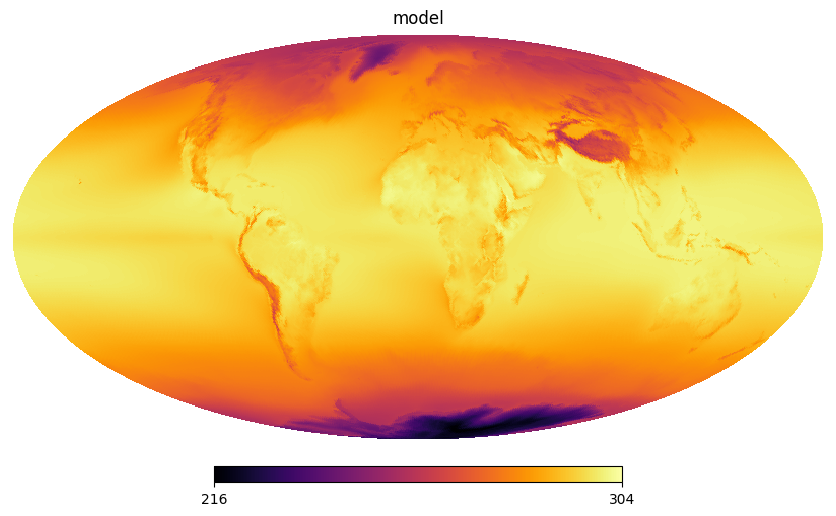

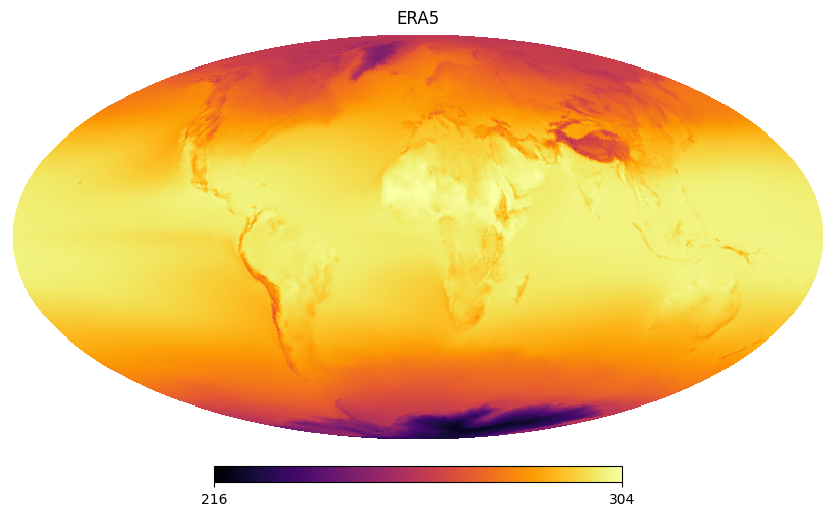

In [4]:
params = dict(flip="geo", nest=True, cmap="inferno", min=216, max=304)
hp.mollview(t_mean_model, **params)
plt.title("model")
plt.savefig("images/model_tas.png")
hp.mollview(t_mean_obs, **params)
plt.title("ERA5")
plt.savefig("images/era_tas.png")

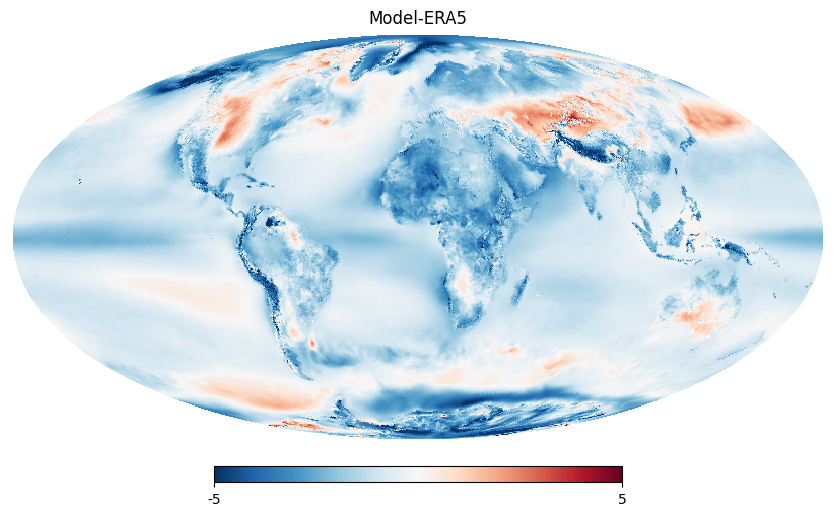

In [5]:
params_diff = dict(cmap="RdBu_r", min=-5, max=5, flip="geo", nest=True)
hp.mollview(t_mean_model - t_mean_obs, **params_diff)
plt.title("Model-ERA5")
plt.savefig("images/t_mean_diff.png", dpi=120)

In [6]:
icon_tas_ts = cat.ICON.ngc3028.to_dask().tas.mean(dim="cell")
timeslice = slice(icon_tas_ts.time[0], icon_tas_ts.time[-1])
hera_tas_ts = hera["2t"].sel(time=timeslice).mean(dim="cell")

/usr/local/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


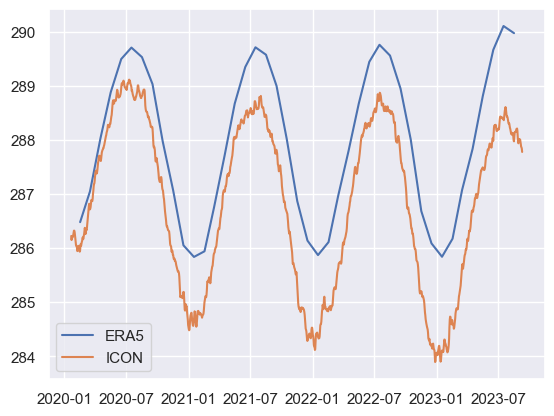

In [7]:
import seaborn as sns

sns.set_theme()
plt.plot(hera_tas_ts.time, hera_tas_ts, label="ERA5")
plt.plot(icon_tas_ts.time, icon_tas_ts, label="ICON")
plt.legend()
plt.savefig("images/tas_ts_comparison.png")

In [8]:
pr_mean_model = icon.sel(time=timeslice)["pr"].mean(dim="time")
pr_mean_obs = hera.sel(time=timeslice)["tp"].mean(dim="time")

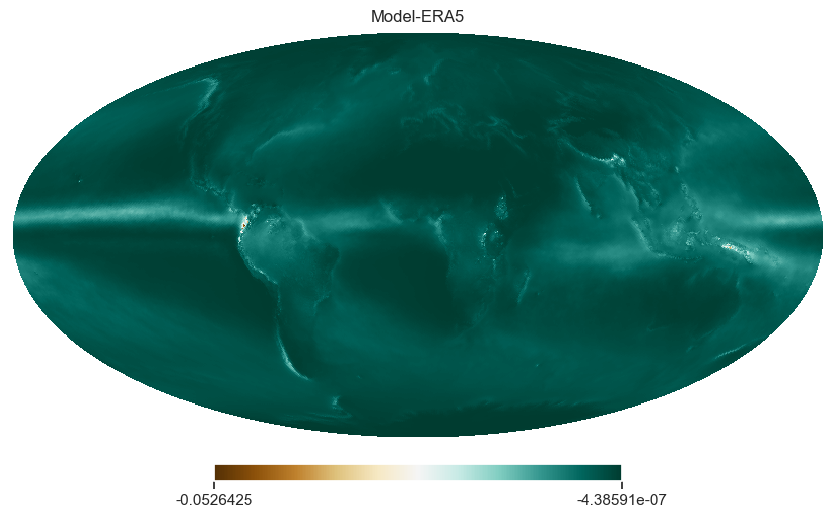

In [9]:
params_pr_diff = dict(cmap="BrBG", flip="geo", nest=True)
hp.mollview(pr_mean_model - pr_mean_obs, **params_pr_diff)
plt.title("Model-ERA5")
plt.savefig("images/pr_mean_diff_wrong.png", dpi=120)

In [10]:
print(f'{icon.pr.attrs["units"]=}\n{hera.tp.attrs["units"]=}')

icon.pr.attrs["units"]='kg m-2 s-1'
hera.tp.attrs["units"]='m/d'


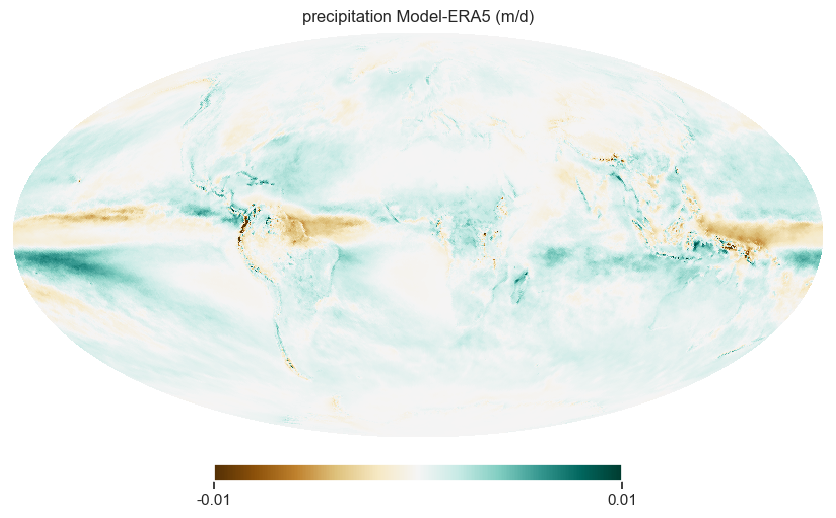

In [11]:
params_pr_diff = dict(cmap="BrBG", flip="geo", nest=True)
hp.mollview(
    pr_mean_model * 86400 / 1000.0 - pr_mean_obs, **params_pr_diff, min=-0.01, max=0.01
)
plt.title("precipitation Model-ERA5 (m/d)")
plt.savefig("images/pr_mean_diff.png")

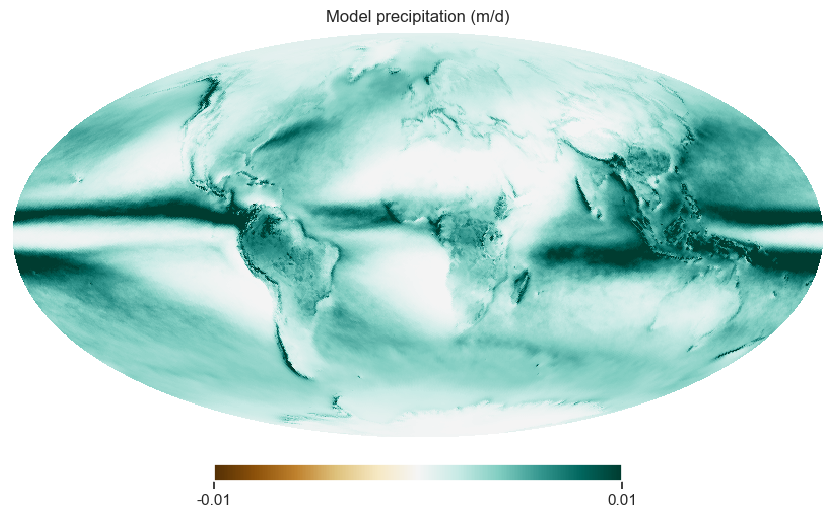

In [12]:
hp.mollview(pr_mean_model * 86400 / 1000, **params_pr_diff, min=-0.01, max=0.01)
plt.title("Model precipitation (m/d)")
plt.savefig("images/pr_mean_model.png")

In [13]:
hera_cat.HERA5.describe()

{'name': 'HERA5',
 'container': 'xarray',
 'plugin': ['zarr'],
 'driver': ['zarr'],
 'description': 'Selected variables from ERA5, restructured and saved on the HEALPix grid.',
 'direct_access': 'forbid',
 'user_parameters': [{'name': 'zoom',
   'description': 'HEALPix zoom level',
   'type': 'int',
   'allowed': [7],
   'default': 7},
  {'name': 'time',
   'description': 'Temporal frequency',
   'type': 'str',
   'allowed': ['P1M', 'P1D', 'PT1H'],
   'default': 'P1M'}],
 'metadata': {'title': 'HERA5 - HEALPixelation of ERA5',
  'source': 'Post-processed dataset based on the ERA5 mirror located at DKRZ.',
  'creator': 'Lukas Kluft',
  'institution': 'Max Planck Institute for Meteorology',
  'contact': 'lukas.kluft@mpimet.mpg.de',
  'acknowledgment': 'Contains modified Copernicus Climate Change Service information 2020. Neither the European Commission nor ECMWF is responsible for any use that may be made of the Copernicus information or data it contains.'},
 'args': {'urlpath': ['https:

In [14]:
import numpy as np


# https://mattermost.mpimet.mpg.de/nextgems/pl/swe8gwsjx3yei8ywszm34tcf7c
def hacky_linear_interpolation(data, target_grid, target, dim="level_full"):
    from collections.abc import (
        Iterable,
    )  # import directly from collections for Python < 3.3

    if isinstance(target, Iterable) and len(target) > 1:
        return np.array(
            [hacky_linear_interpolation(data, target_grid, y, dim) for y in target]
        )
    else:
        level_above = (target_grid > target).argmax(dim=dim)
        level_below = level_above - 1
        value_above = target_grid.isel(**{dim: level_above})
        value_below = target_grid.isel(**{dim: level_below})
        f = (target - value_below) / (value_above - value_below)
        interpolated = (1 - f) * data.isel(**{dim: level_below}) + f * data.isel(
            **{dim: level_above}
        )
        return np.where(level_above > 0, interpolated, np.nan)

In [15]:
target = hera.u.level.values

In [16]:
interpolated = hacky_linear_interpolation(
    icon.ua.sel(time=timeslice).mean(dim="time").compute(),
    icon.pfull.sel(time=timeslice).mean(dim="time").compute(),
    target * 100,
)

In [17]:
import xarray as xr

icon_on_pl = xr.Dataset(
    dict(
        level=target,
        crs=icon.crs,
        ua=xr.DataArray(
            interpolated,
            name="ua",
            attrs=dict(grid_mapping="crs"),
            dims=("level", "cell"),
        ),
    )
).pipe(attach_coords)

In [18]:
icon_ua = icon_on_pl.ua.groupby("lat").mean().compute()
hera_ua = hera.u.sel(time=timeslice).mean(dim="time").groupby("lat").mean().compute()

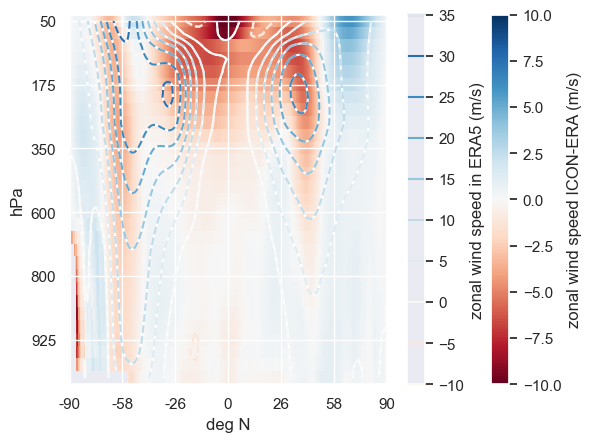

In [35]:
plt.imshow(
    icon_ua - hera_ua,
    aspect="auto",
    cmap="RdBu",
    vmin=-10,
    vmax=10,
    interpolation="nearest",
)
plt.colorbar(label="zonal wind speed ICON-ERA (m/s)")
plt.contour(hera_ua, vmin=-40, vmax=40, colors="white")
plt.contour(hera_ua, cmap="RdBu", vmin=-40, vmax=40, linestyles="dashed")
plt.colorbar(label="zonal wind speed in ERA5 (m/s)")
yticks = range(0, len(target), 5)
plt.yticks(yticks, [str(target[x]) for x in yticks])
plt.ylabel("hPa")
xticks = range(0, len(hera_ua.lat), len(hera_ua.lat) // 6)
plt.xticks(xticks, [f"{hera_ua.lat.values[x]:.0f}" for x in xticks])
plt.xlabel("deg N")
plt.savefig("images/ua-diff-vs-obs.png")